In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
import random
from datetime import timedelta
import random
import math

In [2]:
# importing dataset
df = pd.read_csv('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [19]:
# users who responded
respondent_df = df[(df['yes']==1)|(df['no']==1)]

In [20]:
class SequentialABTesting:
    def __init__(self, data, category, exposed, controlled,N=5):
        self.N = N
        self.data = data
        self.exposed = self.data[self.data[category]==exposed]
        self.controlled = self.data[self.data[category]==controlled]
    
    def treatment_success(self, success):
        self.treatment_success_count = len(self.exposed[self.exposed[success]==1])
        return self.treatment_success_count
    
    def controlled_success(self, success):
        self.controlled_success_count = len(self.controlled[self.controlled[success]==1])
        return self.controlled_success_count
    
    def testing(self):
        T = self.treatment_success_count
        C = self.controlled_success_count
        summation = T+C
        difference = T-C
        response = None
        for i in range(1,self.N):
            if difference ==int(2/np.sqrt(i)):
                response = 1
                break
            if summation == int(i):
                response = -1
                break
        if response == 1:
            return 'Treatment is the winner', response
        if response == -1:
            return 'No winner', response
        return 'No response, increase the sample size',response

In [21]:
# testing sequentialtesting
obj = SequentialABTesting(respondent_df, 'experiment','exposed','controlled',N=1000)
obj.treatment_success('yes')
obj.controlled_success('yes')
obj.testing() 

('No winner', -1)

In [22]:
import abc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import sys


# SPRT test
class SPRT:

    __metaclass__ = abc.ABCMeta
  
    """Run sequential probability ratio test (SPRT) for bindary/normal endpoints"""
    # Init function
    def __init__(self, alpha=0.05, beta=0.2,
                 h0=0, h1=1, values=[], variance=0):

        # Input arguments
        self.alpha = alpha
        self.beta = beta
        self.h0 = h0
        self.h1 = h1
        self.values = values
        self.cum_values = np.cumsum(self.values)
        self.variance = variance
        # Necessary arguments
        self.upperCritical = np.log((1 - self.beta)/self.alpha)
        self.lowerCritical = np.log(self.beta/(1 - self.alpha))
        self.num_observation = len(values)
        self._seq_observation = np.array(range(1, self.num_observation + 1))
        self._x = np.array(range(0, self.num_observation + 2))
        self._yl = self._yu = np.ones(self.num_observation + 2)
        self.decision = None
        # Check the arguments
        self.__checkCommonArgs()
        self.__checkOtherArgs()
        # Calculate boundary
        self.calBoundary()
        # Sequential test
        self.seqTest()

    # Check common arguments in the fuction
    def __checkCommonArgs(self):

        if not all(0 < i < 1 for i in [self.alpha, self.beta]):

            sys.stderr.write("Type I error rate and type II error rate are between 0 and 1!")
            sys.exit(1)

    # Plot the boundary and points
    def plot(self, boundaryColor=["#00aedb", "#d41243",  "#000000"],  pointColor="#000000", fill=True):

        lowerBoundaryColor, upperBoundaryColor, continueColor = boundaryColor
        fig, ax = plt.subplots(figsize=(8, 6))
        lower_line, = ax.plot(self._x, self._yl, color=lowerBoundaryColor, linewidth=1, alpha=0.95)
        upper_line, = ax.plot(self._x, self._yu, color=upperBoundaryColor,  linewidth=1,  alpha=0.95)
        ax.scatter(self._seq_observation, self.cum_values, color=pointColor, zorder=1000, clip_on=False)
        yticks, yticklabels = plt.yticks()
        ymin = yticks[0]
        ymax = yticks[-1]
        if fill:

            ax.fill_between(self._x, self._yl, ymin, color=lowerBoundaryColor, alpha=0.5)
            ax.fill_between(self._x, self._yu, ymax, color=upperBoundaryColor, alpha=0.5)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        xticks, xticklabels = plt.xticks()
        xmin = 0.95
        xmax = self.num_observation + 0.05
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.xlabel("Observations")
        plt.ylabel("Cumulative Sum")
        plt.legend(handles=[upper_line, lower_line], labels=["Reject Null", "Accept Null"], fontsize=10, loc=2)
        plt.show()

    # Plot only the boundary values
    def plotBoundary(self, boundaryColor=["#00aedb", "#d41243"],  fill=True):

        lowerBoundaryColor, upperBoundaryColor = boundaryColor
        fig, ax = plt.subplots(figsize=(8, 6))
        lower_line, = ax.plot(self._x, self._yl, color=lowerBoundaryColor, linewidth=1)
        upper_line, = ax.plot(self._x, self._yu, color=upperBoundaryColor, linewidth=1)
        yticks, yticklabels = plt.yticks()
        ymin = yticks[0]
        ymax = yticks[-1]
        if fill:

            ax.fill_between(self._x, self._yl, ymin, color=lowerBoundaryColor, alpha=0.5)
            ax.fill_between(self._x, self._yu, ymax, color=upperBoundaryColor, alpha=0.5)

        ax.spines["top"].set_visible(False) 
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.xlim(1, self.num_observation)
        plt.ylim(ymin, ymax)
        plt.xlabel("Observations")
        plt.ylabel("Cumulative Sum")
        plt.legend(handles = [upper_line, lower_line], labels=["Reject Null", "Accept Null"], fontsize = 10, loc = 2)
        plt.show()

    # Get test result
    def getResult(self, nobs=5, start="end"):

        print("Decision:\t" + self.decision + "\n")
        output_dict = {'values': self.cum_values, 'lower': self.lowerBoundary, 'upper': self.upperBoundary}
        output_df = pd.DataFrame(output_dict, columns=['values', 'lower', 'upper'], index=self._seq_observation)
        output_df.index.name = "n"
        print(output_df.round(3).iloc[-nobs:])

    # Sequential test
    def seqTest(self):

        self.test_statistic = self.cum_values[self.num_observation - 1]
        if self.test_statistic > self.upperBoundary[self.num_observation - 1]:

            self.decision = "Reject"

        elif self.test_statistic < self.lowerBoundary[self.num_observation - 1]:

            self.decision = "Accept"

        else:

            self.decision = "Continue"

        header = 10 if self.num_observation > 10 else self.num_observation
        self.getResult(nobs=header)

    # Abstract method, calculate the boundary by time
    @abc.abstractmethod
    def calBoundary(self):

        return

    # Abstarct method, function to check other input arguments
    @abc.abstractmethod
    def __checkOtherArgs(self):

        return


# Binary Endpoint
class SPRTBinomial(SPRT):

    """Run sequential probability ratio test (SPRT) for bindary endpoints"""
    # Calculate boundary for binary outcome
    def calBoundary(self):

        self.denom = (np.log(self.h1/(1 - self.h1)) - np.log(self.h0/(1 - self.h0)))
        self.slope = (np.log(1 - self.h0) - np.log(1 - self.h1)) / self.denom
        self.lowerIntercept, self.upperIntercept = np.array([self.lowerCritical, self.upperCritical]) / self.denom
        self.lowerBoundary = self._seq_observation * self.slope + self.lowerIntercept
        self.upperBoundary = self._seq_observation * self.slope + self.upperIntercept
        self._yl = self._x * self.slope + self.lowerIntercept
        self._yu = self._x * self.slope + self.upperIntercept

    # Check arguments
    def _SPRT__checkOtherArgs(self):

        # Check h0 and h1
        if not all(0 < i < 1 for i in [self.h0, self.h1]):

            sys.stderr.write("Null and alternative values are between 0 and 1!")
            sys.exit(1)

        # Check values
        if not all(i in [0, 1] for i in self.values):

            sys.stderr.write("Value is a Beroulli variable!")
            sys.exit(1)

Decision:	Accept

      values    lower    upper
n                             
1234     567  639.881  650.831
1235     568  640.406  651.356
1236     569  640.931  651.881
1237     570  641.456  652.406
1238     570  641.982  652.931
1239     571  642.507  653.456
1240     572  643.032  653.981
1241     572  643.557  654.506
1242     572  644.082  655.031
1243     572  644.607  655.556


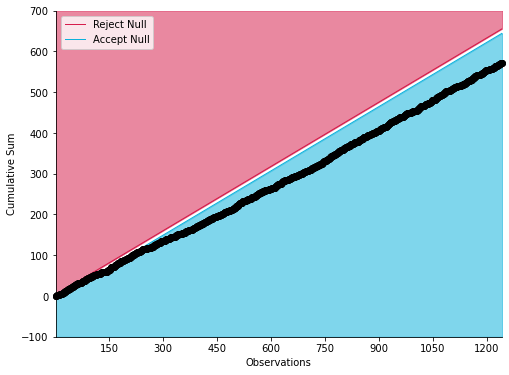

In [23]:
# import sprt as sprt
import numpy as np

# Null value
h0 = 0.5
# Alternative value
h1 = 0.55
# Type I error rate = 0.05
alpha = 0.5
# Type II error rate = 0.2
beta = 0.10
# Values
values = list(respondent_df['yes'])
test = SPRTBinomial(h0 = h0, h1 = h1, alpha = alpha, beta = beta, values = values)
test.plot()

## interpretation
From the graph, it is highly recommended to accept the null hypothesis

NB: we can't fully accept the null hypothesis but we say that we failed to reject the null hypothesis.